In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings('ignore')
from typing import defaultdict
from scipy.stats.mstats import winsorize
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data_path = '..\\data\\'

In [3]:
transactions = pd.read_csv(data_path + 'train_data_npo\\npo_trnsctns.csv')

In [4]:
def columns_report(data: pd.DataFrame) -> None:

    print('Rows:', data.shape[0], end='\n'*2)

    stats = defaultdict(list)
    for col in data.columns:
        stats['Column'].append(col)
        stats['Unique'].append(data[col].nunique())
        stats['Duplicates'].append(data[col].duplicated().sum())
        stats['Missing'].append(data[col].isna().sum())
        stats['Missing%'].append(data[col].isna().mean() * 100)
        stats['HitRate%'].append((1 - data[col].isna().mean()) * 100)
    stats = pd.DataFrame(stats)

    print(stats.to_string(index=False))

In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12325096 entries, 0 to 12325095
Data columns (total 5 columns):
 #   Column               Dtype  
---  ------               -----  
 0   npo_accnt_id         object 
 1   npo_sum              float64
 2   slctn_nmbr           int64  
 3   npo_operation_date   object 
 4   npo_operation_group  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 470.2+ MB


In [6]:
columns_report(transactions)

Rows: 12325096

             Column  Unique  Duplicates  Missing  Missing%  HitRate%
       npo_accnt_id  241359    12083737        0       0.0     100.0
            npo_sum 1023570    11301526        0       0.0     100.0
         slctn_nmbr       4    12325092        0       0.0     100.0
 npo_operation_date    7977    12317119        0       0.0     100.0
npo_operation_group       2    12325094        0       0.0     100.0


In [7]:
transactions.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

,npo_sum,slctn_nmbr,npo_operation_group
count,1.232510e+07,1.232510e+07,1.232510e+07
mean,3.915640e+03,1.447108e+00,2.120287e-01
std,2.586028e+06,8.332349e-01,4.087451e-01
min,-6.956180e+06,0.000000e+00,0.000000e+00
1%,-2.439000e+01,0.000000e+00,0.000000e+00
10%,2.210000e+01,0.000000e+00,0.000000e+00
25%,1.626000e+02,1.000000e+00,0.000000e+00
50%,6.082900e+02,2.000000e+00,0.000000e+00
75%,1.792300e+03,2.000000e+00,0.000000e+00
90%,4.026000e+03,2.000000e+00,1.000000e+00


In [8]:
def preprocess_transactions(data: pd.DataFrame) -> pd.DataFrame:

    data = data[(data.npo_sum > 0) & (data.npo_operation_group == 0)]
    data['npo_operation_date'] = pd.to_datetime(data.npo_operation_date) + pd.DateOffset(days=487)

    return data

In [9]:
transactions_cleaned = transactions.copy()
transactions_cleaned = preprocess_transactions(transactions_cleaned)

In [10]:
columns_report(transactions_cleaned)

Rows: 9329532

             Column  Unique  Duplicates  Missing  Missing%  HitRate%
       npo_accnt_id  233125     9096407        0       0.0     100.0
            npo_sum  872864     8456668        0       0.0     100.0
         slctn_nmbr       4     9329528        0       0.0     100.0
 npo_operation_date    7929     9321603        0       0.0     100.0
npo_operation_group       1     9329531        0       0.0     100.0


In [11]:
transactions_cleaned.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

,npo_sum,slctn_nmbr,npo_operation_date,npo_operation_group
count,9.329532e+06,9.329532e+06,9329532,9329532.0
mean,4.294357e+03,1.543929e+00,2014-10-24 09:18:47.737436928,0.0
min,1.000000e-02,0.000000e+00,1994-05-14 00:00:00,0.0
1%,2.904000e+01,0.000000e+00,2005-11-21 00:00:00,0.0
10%,1.626000e+02,0.000000e+00,2008-02-20 00:00:00,0.0
25%,2.439000e+02,1.000000e+00,2010-09-06 00:00:00,0.0
50%,8.130000e+02,2.000000e+00,2014-10-14 00:00:00,0.0
75%,2.011650e+03,2.000000e+00,2019-03-06 00:00:00,0.0
90%,4.130890e+03,2.000000e+00,2021-08-11 00:00:00,0.0
99%,1.556097e+04,3.000000e+00,2023-04-06 00:00:00,0.0


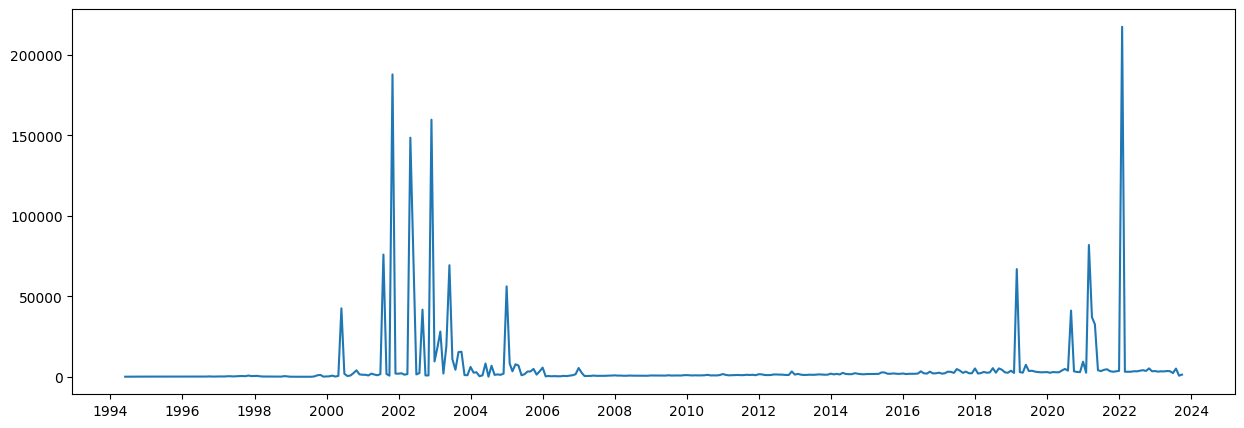

In [12]:
transactions_cleaned['month'] = (transactions_cleaned.npo_operation_date + pd.tseries.offsets.MonthEnd(0)).dt.date

data_to_plot_target = transactions_cleaned.groupby('month', as_index=False).npo_sum.mean()
data_to_plot_target['month'] = pd.to_datetime(data_to_plot_target.month)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data_to_plot_target.month, data_to_plot_target.npo_sum)
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [13]:
transactions_cleaned['winsorized_npo_sum'] = winsorize(transactions_cleaned.npo_sum, limits=.05)

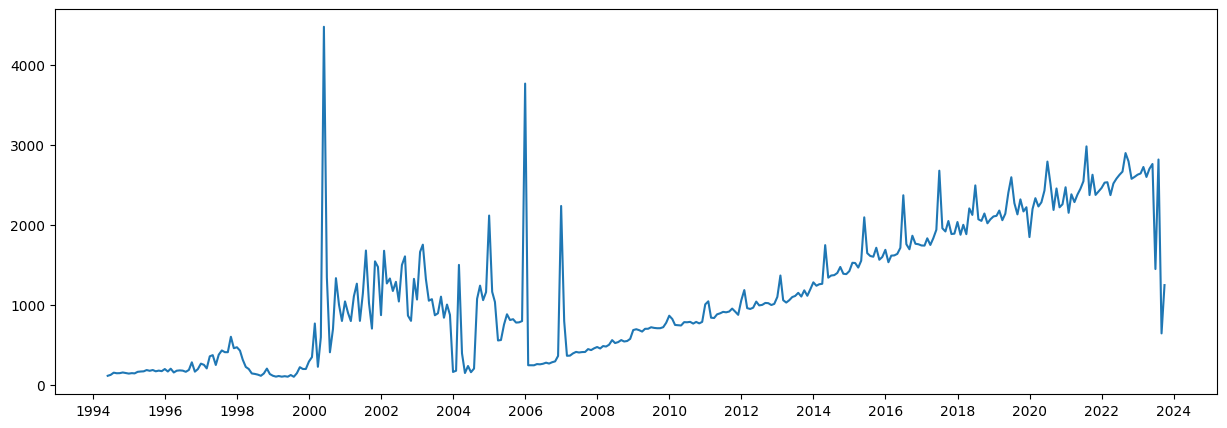

In [14]:
data_to_plot_target = transactions_cleaned.groupby('month', as_index=False).winsorized_npo_sum.mean()
data_to_plot_target['month'] = pd.to_datetime(data_to_plot_target.month)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data_to_plot_target.month, data_to_plot_target.winsorized_npo_sum)
ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()

In [15]:
transactions_cleaned = transactions_cleaned[transactions_cleaned.npo_operation_date >= '2008-01-01'].reset_index(drop=True)
transactions_cleaned['winsorized_npo_sum'] = winsorize(transactions_cleaned.npo_sum, limits=.01)

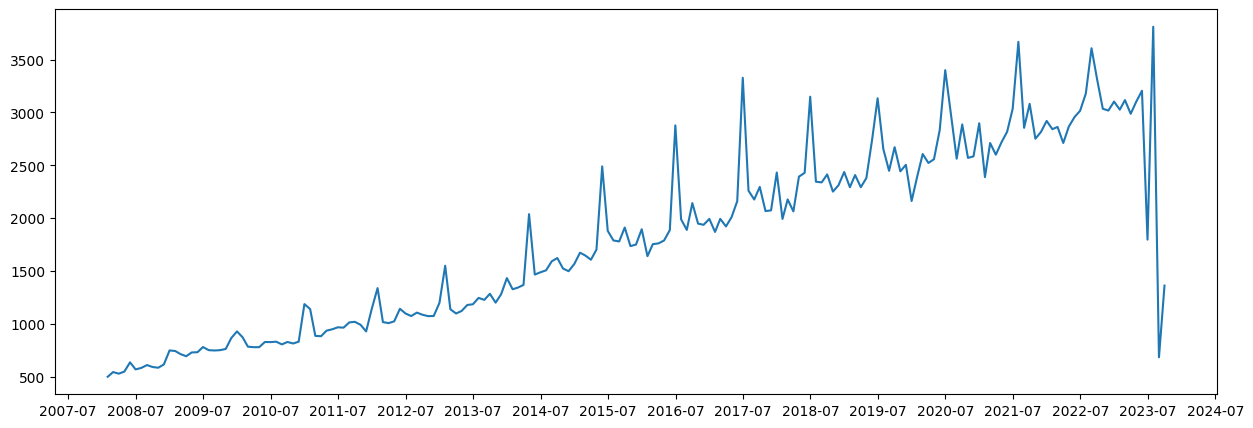

In [16]:
data_to_plot_target = transactions_cleaned.groupby('month', as_index=False).winsorized_npo_sum.mean()
data_to_plot_target['month'] = pd.to_datetime(data_to_plot_target.month)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data_to_plot_target.month, data_to_plot_target.winsorized_npo_sum)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

In [17]:
transactions_cleaned = transactions_cleaned[transactions_cleaned.npo_operation_date < '2023-06-01'].reset_index(drop=True)
transactions_cleaned['winsorized_npo_sum'] = winsorize(transactions_cleaned.npo_sum, limits=.01)

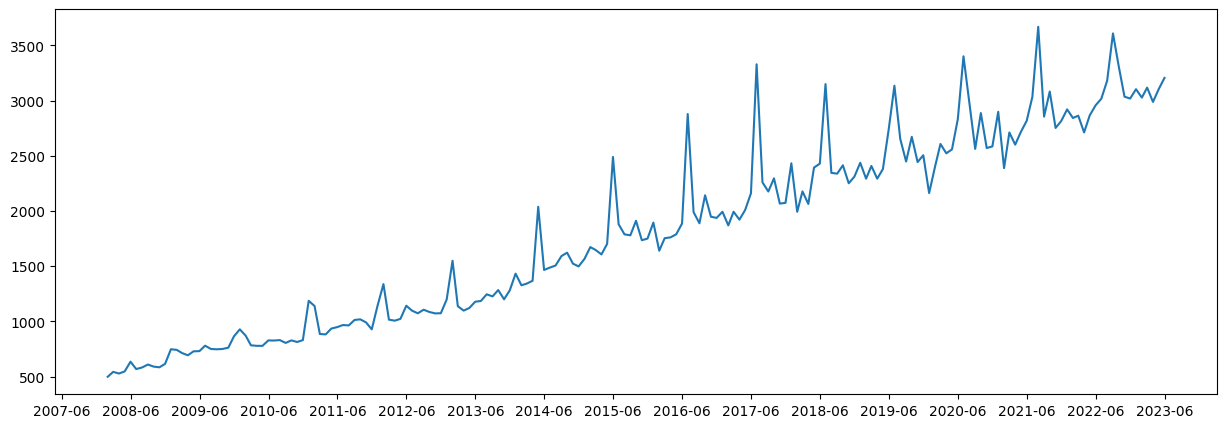

In [22]:
data_to_plot_target = transactions_cleaned.groupby('month', as_index=False).winsorized_npo_sum.mean()
data_to_plot_target['month'] = pd.to_datetime(data_to_plot_target.month)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(data_to_plot_target.month, data_to_plot_target.winsorized_npo_sum)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=6))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

In [56]:
transactions_cleaned['quarter'] = transactions_cleaned.npo_operation_date.dt.to_period('Q')

target_ts = transactions_cleaned.groupby('quarter').winsorized_npo_sum.mean()

seasonal_decomposed_target = seasonal_decompose(target_ts, model='multiplicative', extrapolate_trend='freq', period=4)
seasonal_component = seasonal_decomposed_target.seasonal.reset_index()

In [65]:
def generate_target(data: pd.DataFrame) -> pd.DataFrame:

    data['quarter'] = data.npo_operation_date.dt.to_period('Q')

    data = data.groupby(['npo_accnt_id', 'quarter']).agg(
        {'slctn_nmbr' : 'count', 'winsorized_npo_sum': 'mean'}).reset_index().rename(columns={
            'slctn_nmbr': 'transactions_count', 'winsorized_npo_sum': 'paid_avg'}).reset_index(drop=True)

    return data

In [92]:
target_data = generate_target(transactions_cleaned)

In [93]:
columns_report(target_data)

Rows: 2947320

            Column  Unique  Duplicates  Missing  Missing%  HitRate%
      npo_accnt_id  188429     2758891        0       0.0     100.0
           quarter      62     2947258        0       0.0     100.0
transactions_count      28     2947292        0       0.0     100.0
          paid_avg 1285319     1662001        0       0.0     100.0


In [94]:
target_data = target_data.merge(seasonal_component, how='left', on='quarter')
target_data['paid_avg_correct'] = target_data.paid_avg / target_data.seasonal

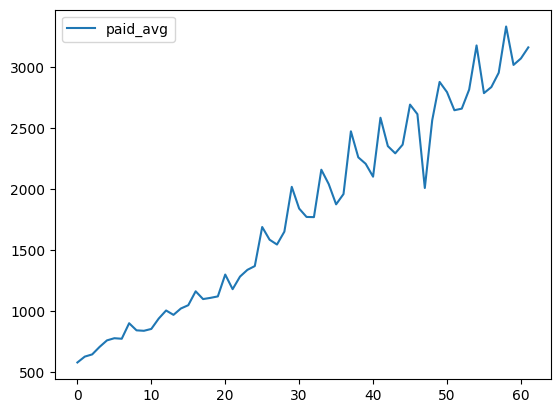

In [98]:
target_data.groupby('quarter', as_index=False).paid_avg.mean().plot()
plt.show()

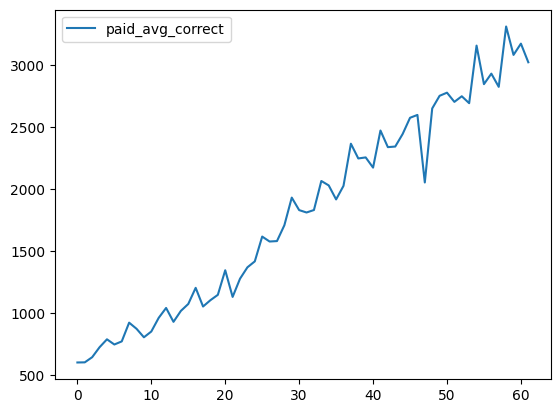

In [97]:
target_data.groupby('quarter', as_index=False).paid_avg_correct.mean().plot()
plt.show()

In [100]:
# target_data.to_feather(data_path + 'interim\\correct_target.frt')